In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import requests
import json
from lib import MongoHandler, WeatherGetter
import sqlite3
import pandas as pd
import math
import pymongo
import numpy as np

In [3]:
conn = sqlite3.connect('database.sqlite')
cur = conn.cursor()

In [4]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

[('sqlite_sequence',), ('Matches',), ('Teams_in_Matches',), ('Teams',), ('Unique_Teams',)]


In [5]:
unique_teams = cur.execute('''SELECT *
            FROM Unique_Teams
            ''').fetchall()

In [6]:
unique_teams[:5]

[('Bayern Munich', 1),
 ('Dortmund', 2),
 ('Leverkusen', 3),
 ('RB Leipzig', 4),
 ('Schalke 04', 5)]

In [7]:
unique_teams_list = [team[0] for team in unique_teams]
unique_teams_list[0:5]

['Bayern Munich', 'Dortmund', 'Leverkusen', 'RB Leipzig', 'Schalke 04']

In [8]:
len(unique_teams_list)

128

In [10]:
teams = cur.execute('''SELECT *
            FROM Teams
            LIMIT 1''').fetchall()

In [11]:
teams

[('2017', 'Bayern Munich', '27', '26', '15', '597950000', '22150000', '75000')]

In [14]:
team_pragma = cur.execute("PRAGMA table_info(Teams)").fetchall()
team_pragma


[(0, 'Season', 'TEXT', 0, None, 0),
 (1, 'TeamName', 'TEXT', 0, None, 0),
 (2, 'KaderHome', 'TEXT', 0, None, 0),
 (3, 'AvgAgeHome', 'TEXT', 0, None, 0),
 (4, 'ForeignPlayersHome', 'TEXT', 0, None, 0),
 (5, 'OverallMarketValueHome', 'TEXT', 0, None, 0),
 (6, 'AvgMarketValueHome', 'TEXT', 0, None, 0),
 (7, 'StadiumCapacity', 'TEXT', 0, None, 0)]

In [15]:
rows = cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")
tables = [row[0] for row in rows]

def sql_identifier(s):
    return '"' + s.replace('"', '""') + '"'

for table in tables:
    print("table: " + table)
    rows = cur.execute("PRAGMA table_info({})".format(sql_identifier(table)))
    print(rows.fetchall())
    rows = cur.execute("PRAGMA foreign_key_list({})".format(sql_identifier(table)))
    print(rows.fetchall())

table: sqlite_sequence
[(0, 'name', '', 0, None, 0), (1, 'seq', '', 0, None, 0)]
[]
table: Matches
[(0, 'Match_ID', 'INTEGER', 1, None, 1), (1, 'Div', 'TEXT', 0, None, 0), (2, 'Season', 'INT', 0, None, 0), (3, 'Date', 'TEXT', 0, None, 0), (4, 'HomeTeam', 'TEXT', 0, None, 0), (5, 'AwayTeam', 'TEXT', 0, None, 0), (6, 'FTHG', 'INT', 0, None, 0), (7, 'FTAG', 'INT', 0, None, 0), (8, 'FTR', 'TEXT', 0, None, 0)]
[]
table: Teams_in_Matches
[(0, 'Match_ID', 'INT', 0, None, 0), (1, 'Unique_Team_ID', 'INT', 0, None, 0)]
[]
table: Teams
[(0, 'Season', 'TEXT', 0, None, 0), (1, 'TeamName', 'TEXT', 0, None, 0), (2, 'KaderHome', 'TEXT', 0, None, 0), (3, 'AvgAgeHome', 'TEXT', 0, None, 0), (4, 'ForeignPlayersHome', 'TEXT', 0, None, 0), (5, 'OverallMarketValueHome', 'TEXT', 0, None, 0), (6, 'AvgMarketValueHome', 'TEXT', 0, None, 0), (7, 'StadiumCapacity', 'TEXT', 0, None, 0)]
[]
table: Unique_Teams
[(0, 'TeamName', 'TEXT', 0, None, 0), (1, 'Unique_Team_ID', 'INTEGER', 0, None, 1)]
[]


In [16]:
matches_pragma = cur.execute("PRAGMA table_info(matches)").fetchall()
matches_pragma


[(0, 'Match_ID', 'INTEGER', 1, None, 1),
 (1, 'Div', 'TEXT', 0, None, 0),
 (2, 'Season', 'INT', 0, None, 0),
 (3, 'Date', 'TEXT', 0, None, 0),
 (4, 'HomeTeam', 'TEXT', 0, None, 0),
 (5, 'AwayTeam', 'TEXT', 0, None, 0),
 (6, 'FTHG', 'INT', 0, None, 0),
 (7, 'FTAG', 'INT', 0, None, 0),
 (8, 'FTR', 'TEXT', 0, None, 0)]

In [17]:
matches = cur.execute('''SELECT *
            FROM Matches
            WHERE Season = 2011''').fetchall()


In [18]:
matches_df = pd.DataFrame(matches)

In [19]:
matches_df.head()

,0,1,2,3,4,5,6,7,8
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D


In [20]:
matches_df.rename(columns={0:"match_id", 1:"Div", 2:'season', 3:"Date1", 4:"home_team", 5:"away_team", 6:'FTHG', 7:"FTAG", 8:'FTR'}, inplace= True)

In [21]:
matches_df.head()

,match_id,Div,season,Date1,home_team,away_team,FTHG,FTAG,FTR
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D


In [23]:
matches_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 9 columns):
match_id     992 non-null int64
Div          992 non-null object
season       992 non-null int64
Date1        992 non-null object
home_team    992 non-null object
away_team    992 non-null object
FTHG         992 non-null int64
FTAG         992 non-null int64
FTR          992 non-null object
dtypes: int64(4), object(5)
memory usage: 69.9+ KB


In [22]:
dates = matches_df['Date1'].unique()

In [24]:
matches_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 9 columns):
match_id     992 non-null int64
Div          992 non-null object
season       992 non-null int64
Date1        992 non-null object
home_team    992 non-null object
away_team    992 non-null object
FTHG         992 non-null int64
FTAG         992 non-null int64
FTR          992 non-null object
dtypes: int64(4), object(5)
memory usage: 69.9+ KB


In [25]:
d1 = dates[0]+'T15:00:00'

In [26]:
d1

'2012-03-31T15:00:00'

In [27]:
dates_list = []
for d in dates:
    dates_list.append(d+'T15:00:00')

dates_list[:5]

['2012-03-31T15:00:00',
 '2011-12-11T15:00:00',
 '2011-08-13T15:00:00',
 '2011-11-27T15:00:00',
 '2012-02-18T15:00:00']

In [30]:
get_weather = WeatherGetter()

In [31]:
test_api = get_weather.weather_getter(d1)

In [32]:
result = test_api.json()

In [33]:
result

{'latitude': 52.52,
 'longitude': 13.405,
 'timezone': 'Europe/Berlin',
 'currently': {'time': 1333198800,
  'summary': 'Mostly Cloudy',
  'icon': 'partly-cloudy-day',
  'precipIntensity': 0,
  'precipProbability': 0,
  'temperature': 41.31,
  'apparentTemperature': 34.25,
  'dewPoint': 34.32,
  'humidity': 0.76,
  'windSpeed': 12.67,
  'windGust': 25.29,
  'windBearing': 311,
  'cloudCover': 0.75,
  'uvIndex': 3,
  'visibility': 6.216},
 'offset': 2}

In [34]:
d={}
for date in dates_list:
    call = get_weather.weather_getter(date)
    result = call.json()
    
    d[date]=result['currently'].get('icon') if result['currently'].get('icon') else result['currently'].get('summary')

In [35]:
weather_dict = {}
for i in d:
    weather_dict[i[:10]] = d[i]
    

In [36]:
weather_dict

{'2012-03-31': 'partly-cloudy-day',
 '2011-12-11': 'partly-cloudy-day',
 '2011-08-13': 'partly-cloudy-day',
 '2011-11-27': 'partly-cloudy-day',
 '2012-02-18': 'partly-cloudy-day',
 '2012-01-20': 'partly-cloudy-day',
 '2012-02-04': 'clear-day',
 '2012-04-21': 'partly-cloudy-day',
 '2011-09-18': 'partly-cloudy-day',
 '2011-10-23': 'rain',
 '2011-10-01': 'Clear',
 '2012-03-03': 'Clear',
 '2011-08-27': 'partly-cloudy-day',
 '2012-03-17': 'Clear',
 '2011-11-06': 'Clear',
 '2012-05-05': 'partly-cloudy-day',
 '2012-04-11': 'partly-cloudy-day',
 '2011-12-17': 'partly-cloudy-day',
 '2012-02-03': 'partly-cloudy-day',
 '2011-10-29': 'Clear',
 '2012-01-22': 'partly-cloudy-day',
 '2011-12-03': 'rain',
 '2012-04-14': 'partly-cloudy-day',
 '2012-03-25': 'Clear',
 '2012-03-10': 'partly-cloudy-day',
 '2012-04-07': 'partly-cloudy-day',
 '2011-11-19': 'Clear',
 '2011-10-14': 'partly-cloudy-day',
 '2011-09-24': 'clear-day',
 '2012-04-28': 'Clear',
 '2011-12-18': 'rain',
 '2012-03-02': 'partly-cloudy-day',

In [37]:
matches_df['weather'] = matches_df['Date1'].map(weather_dict)

In [38]:
matches_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 10 columns):
match_id     992 non-null int64
Div          992 non-null object
season       992 non-null int64
Date1        992 non-null object
home_team    992 non-null object
away_team    992 non-null object
FTHG         992 non-null int64
FTAG         992 non-null int64
FTR          992 non-null object
weather      992 non-null object
dtypes: int64(4), object(6)
memory usage: 77.6+ KB


In [39]:
matches_df.head()

,match_id,Div,season,Date1,home_team,away_team,FTHG,FTAG,FTR,weather
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A,partly-cloudy-day
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A,partly-cloudy-day
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A,partly-cloudy-day
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H,partly-cloudy-day
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D,partly-cloudy-day


In [40]:
matches_df.head()

,match_id,Div,season,Date1,home_team,away_team,FTHG,FTAG,FTR,weather
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A,partly-cloudy-day
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A,partly-cloudy-day
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A,partly-cloudy-day
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H,partly-cloudy-day
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D,partly-cloudy-day


In [41]:
matches_df['rain_home'] =np.where(np.logical_and(matches_df['FTR']=='H',matches_df['weather']=='rain'),1,0)

In [42]:
matches_df.head()

,match_id,Div,season,Date1,home_team,away_team,FTHG,FTAG,FTR,weather,rain_home
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A,partly-cloudy-day,0
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A,partly-cloudy-day,0
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A,partly-cloudy-day,0
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H,partly-cloudy-day,0
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D,partly-cloudy-day,0


In [43]:
matches_df['rain_away'] =np.where(np.logical_and(matches_df['FTR']=='R',matches_df['weather']=='rain'),1,0)

In [44]:
matches_df.weather.value_counts()

partly-cloudy-day    573
Clear                251
clear-day            103
rain                  59
cloudy                 6
Name: weather, dtype: int64

In [45]:
matches_df['played_in_rain'] = [1 if x == 'rain' else 0 for x in matches_df['weather']]

In [46]:
matches_df['home_wins'] = [1 if x == 'H' else 0 for x in matches_df['FTR']]

In [47]:
matches_df['away_wins'] = [1 if x == 'A' else 0 for x in matches_df['FTR']]

In [48]:
matches_df['draw'] = [1 if x == 'D' else 0 for x in matches_df['FTR']]

In [49]:
import matplotlib.pyplot as plt

In [50]:
list_of_teams = unique_teams_list

In [51]:
len(list_of_teams)

128

In [56]:
mongodb = MongoHandler("football3", 'divisions')

In [57]:
type(mongodb)

lib.MongoHandler

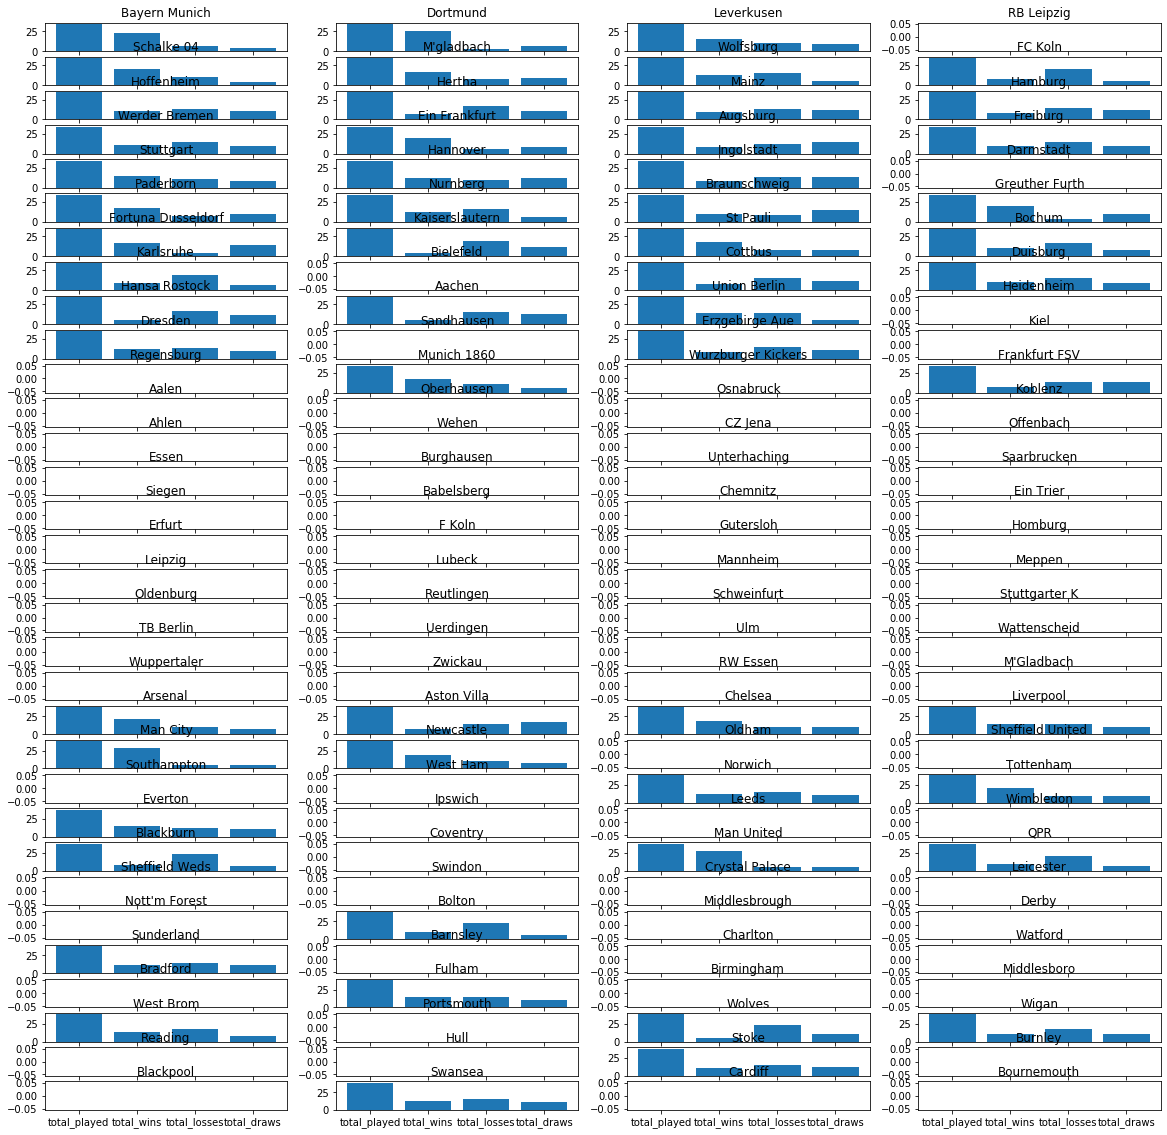

In [58]:
col = 0
rows = 0

# fig, axs = plt.subplots(32, 4, figsize=(20,20), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .5, wspace=.001)
fig = plt.figure(figsize= (20,20))
new_list = []
for i,team in enumerate(list_of_teams):
    team_list = []
    home_team_list = []
    home_df = matches_df.loc[matches_df['home_team'] == team]
    home_df = home_df.append(home_df.sum().rename('Total'))
    home_goals = home_df.iloc[-1]['FTHG']
    home_rain_wins = home_df.iloc[-1]['rain_home']
    home_rain_played = home_df.iloc[-1]['played_in_rain']
    home_wins = home_df.iloc[-1]['home_wins']
    home_played = len(home_df)-1
    home_draws = home_df.iloc[-1]['draw']
    
    
    away_team_list = []
    away_df = matches_df.loc[matches_df['away_team'] == team]
    away_df = away_df.append(away_df.sum().rename('Total'))
    away_goals = away_df.iloc[-1]['FTAG']
    away_rain_wins = away_df.iloc[-1]['rain_away']
    away_rain_played = away_df.iloc[-1]['played_in_rain']
    away_team_list.append(away_df.iloc[-1]['home_wins'])
    away_wins = away_df.iloc[-1]['away_wins']
    away_draws = away_df.iloc[-1]['draw']
    away_played = len(away_df)-1
    
    total_goals = home_goals + away_goals
    total_wins = home_wins + away_wins
    wins_in_rain = home_rain_wins + away_rain_wins
    played_in_rain = home_rain_played + away_rain_played 
    if played_in_rain == 0:
        win_percentage = 0
    else:
        win_percentage = float(wins_in_rain/played_in_rain)
    
    total_played = home_played + away_played
    total_draws = home_draws + away_draws
    total_losses = total_played - (total_wins + total_draws)
    
    team_list.append(team)
    team_list.append(total_goals)
    team_list.append(total_wins)
    team_list.append(win_percentage)
    
 
    mongodb.create_doc(team,int(total_goals),int(total_wins),win_percentage)

    new_list.append(team_list)

    ax = fig.add_subplot(32,4,i+1)
    barx = ['total_played', 'total_wins', 'total_losses', 'total_draws']
    bary = [total_played, total_wins, total_losses, total_draws]
    ax.bar(barx, bary)
    ax.set_title(team)
